### Config

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad


### 4.7

#### a)

Let's define the region of absolute stability for the Heun method and plot this on a contour plot for different values of $h$ and $\lambda$.

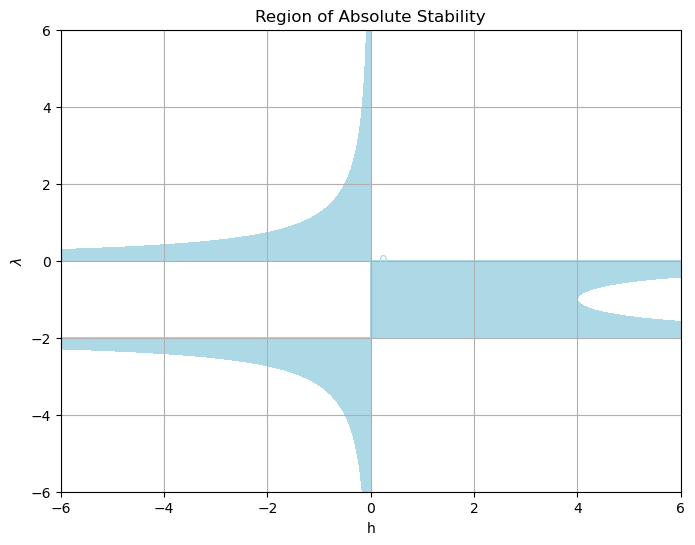

In [2]:
def heun_region(h, lam):
    return np.abs(1 + lam * h + lam**2 * h / 2)

h_vals = np.linspace(-6, 6, 400)
lam_vals = np.linspace(-6, 6, 400)

h, lam = np.meshgrid(h_vals, lam_vals)
region = heun_region(h, lam)

plt.figure(figsize=(8, 6))
c = plt.contourf(h_vals, lam_vals, region, levels=[0, 1], colors=['lightblue'])
plt.clabel(c, inline=True, fontsize=10)
plt.xlabel('h')
plt.ylabel('$\lambda$')
plt.title('Region of Absolute Stability')
plt.grid(True)
plt.show()


Now let's do the same for the Runge-Kutta with Butcher tableau as in 4.6. The region is not given here but we can observe that $u_{n+1} = R(\lambda h)^{n+1}u_0$ so we simply need $|R(\lambda h)|<1$ for absolute stability (with $R(\lambda h)$ defined in 4.6).

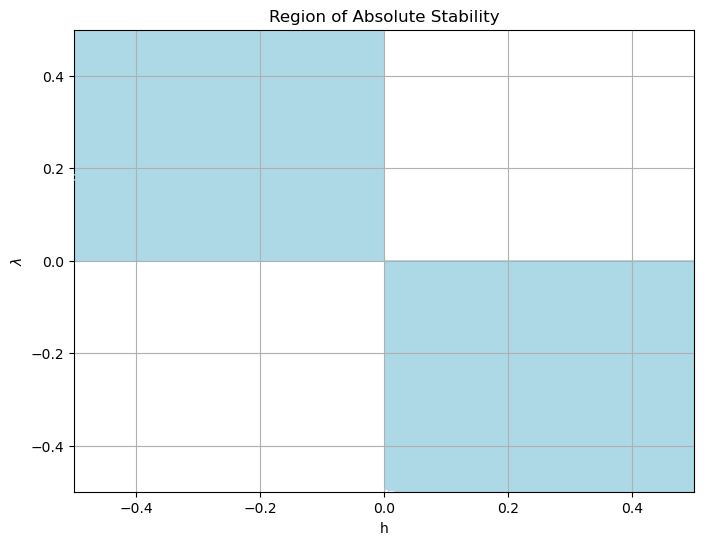

In [3]:
def rk_region(h, lam):
    num = (1 + lam * h / 2 + lam**2 * h**2 / 12)
    den = (1 - lam * h / 2 + lam**2 * h**2 / 12)
    return np.abs(num / den)

h_vals = np.linspace(-0.5, 0.5, 400)
lam_vals = np.linspace(-0.5, 0.5, 400)

h, lam = np.meshgrid(h_vals, lam_vals)
region = rk_region(h, lam)

plt.figure(figsize=(8, 6))
c = plt.contourf(h_vals, lam_vals, region, levels=[0, 1], colors=['lightblue'])
plt.clabel(c, inline=True, fontsize=10)
plt.xlabel('h')
plt.ylabel('$\lambda$')
plt.title('Region of Absolute Stability')
plt.grid(True)
plt.show()


This one is a lot more clear: we simply need exactly one of $h$ or $\lambda$ to be positive and the other to be negative.

### 4.8

#### a)

In [16]:
def evolve(t0, y0, f, Phi, h, N):

    u = [y0]
    t = t0
    
    for n in range(N):
        u.append(Phi(t, u[-1], f, h))
        t += h
    
    return u

def forwardEuler(t, u, f, h):
    return u + h * f(t, u)

def Heun(t, u, f, h):
    euler_estimate = u + h * f(t, u)
    return u + (h/2) * (f(t, u) + f(t + h, euler_estimate))


In [17]:
def lastError(Phi, h, N):
   
    def f(t, y):
        return -(1 + t) * y**2
    
    def y_exact(t):
        return 2 / (t**2 + 2*t + 2)
    
    t0 = 0
    y0 = y_exact(t0)
    
    u = evolve(t0, y0, f, Phi, h, N)
    y_final = y_exact(N*h)
    
    return abs(u[-1] - y_final)

print(lastError(forwardEuler, 0.1, 10))
print(lastError(Heun, 0.1, 10))
    

0.014290426529517009
0.001091196124116789


#### b)

In [15]:
def EOC(hs, es):
    eocs = [np.nan]
    for i in range(1, len(hs)):
        eocs.append(np.log(es[i-1]/es[i])/np.log(hs[i-1])/hs[i])
    return eocs


#### c)

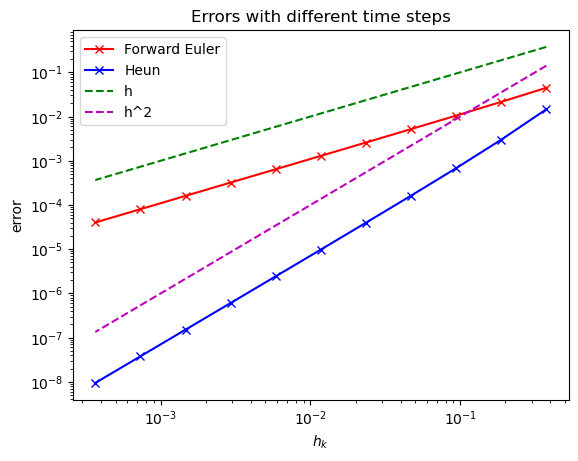

In [39]:
N0, T = 4, 1.5
N_values = [N0 * 2**k for k in range(11)]
h_values = [T / N for N in N_values]

plt.plot(h_values, [lastError(forwardEuler, h_values[i], N_values[i]) for i in range(11)], 'x-r', label='Forward Euler')
plt.plot(h_values, [lastError(Heun, h_values[i], N_values[i]) for i in range(11)], 'x-b', label='Heun')
plt.plot(h_values, h_values, 'g--', label='h')
plt.plot(h_values, [h**2 for h in h_values], 'm--', label='h^2')
plt.xscale('log')
plt.yscale('log')
plt.title('Errors with different time steps')
plt.xlabel('$h_k$')
plt.ylabel('error')
plt.legend()
plt.show()


As we can see Forward Euler is parallel to $h$ and Heun is parallel to $h^2$ which shows that they are of order 1 and 2 respectively.

### 4.9

#### a)

With our assumption of $A$ being of lower triangular and 0 diagonal, we have the following:

$$K_1 = f(t_n + c_1h, u_n)$$
$$K_2 = f(t_n + c_2h, u_n + ha_{21}K_1)$$
$$K_3 = f(t_n + c_3h, u_n + h(a_{31}K_1 + a_{32}K_2)$$

and so on. Hence we can implement our increment function now:

In [56]:
def explicitRK(t, u, f, h, A, b, c):
    
    s = len(b)
    Ks = []
    
    for i in range(s):
        K = f(t + c[i] * h, u + h * sum([A[i][j] * Ks[j] for j in range(i)]))
        Ks.append(K)
        
    phi = np.dot(b, Ks)
    return h * phi


Now we can use this for the given methods. Let's define the three wrapper functions and call them for our IVP and parameters from before.

In [57]:
def for_eul(t, u, f, h):
    A = [0]
    b = [1]
    c = [0]
    return explicitRK(t, u, f, h, A, b, c)

def exp_mid(t, u, f, h):
    A = [[0,0], [1/2,0]]
    b = [0, 1]
    c = [0, 1/2]
    return explicitRK(t, u, f, h, A, b, c)

def RK3(t, u, f, h):
    A = [[0,0,0], [1/2,0,0], [-1,2,0]]
    b = [1/6, 2/3, 1/6]
    c = [0, 1/2, 1]
    return explicitRK(t, u, f, h, A, b, c)


In [72]:
[lastError(RK3, h_values[i], N_values[i]) for i in range(11)]

[0.27587408262203805,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724]

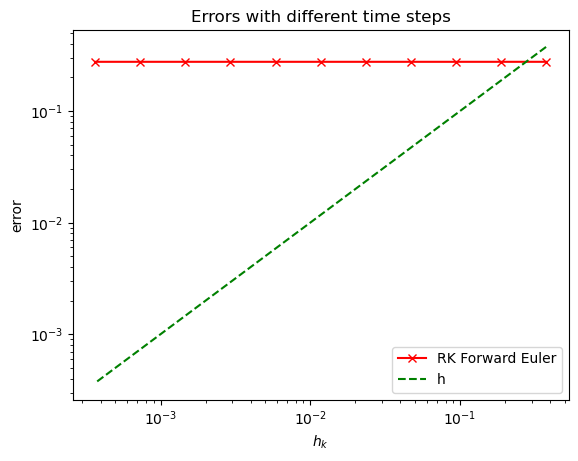

In [70]:
N0, T = 4, 1.5
N_values = [N0 * 2**k for k in range(11)]
h_values = [T / N for N in N_values]

plt.plot(h_values, [lastError(for_eul, h_values[i], N_values[i]) for i in range(11)], 'x-r', label='RK Forward Euler')
plt.plot(h_values, h_values, 'g--', label='h')
plt.xscale('log')
plt.yscale('log')
plt.title('Errors with different time steps')
plt.xlabel('$h_k$')
plt.ylabel('error')
plt.legend()
plt.show()